# Frequency correlation plots for simulated populations with nested clades from a full tree

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [1]:
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] < freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] < freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [6]:
min_clade_frequency = 0.15

In [7]:
precision = 4

In [8]:
data_root = "../results/builds/simulated/simulated_sample_3"

In [9]:
data_root_full_tree = "../results/builds/simulated/simulated_sample_3_full_tree"

In [10]:
first_validation_timepoint = "2023-10-01"

In [11]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [12]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [13]:
#tips = np.round(tips, precision)

In [14]:
np.round(tips.head(1), precision)

,strain,timepoint,frequency
8820,sample_4636_1,2023-10-01,0.0


In [15]:
(tips["frequency"] > 0).sum()

22050

In [16]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root_full_tree, sep="\t",
                             usecols=["tip", "clade_membership", "depth"])

In [17]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [18]:
tips_to_clades.head(20)

,strain,clade_membership,depth
0,sample_6160_82,371216c,0
1,sample_6160_82,bf38b41,2
2,sample_6160_82,adc6bab,3
3,sample_6164_8,371216c,0
4,sample_6164_8,bf38b41,2
5,sample_6164_8,adc6bab,3
6,sample_6156_7,c29d627,0
7,sample_6156_7,441d6bc,2
8,sample_6156_7,bf38b41,3
9,sample_6156_7,adc6bab,4


In [19]:
tips_to_clades.shape

(258040, 3)

In [20]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "frequency", "projected_frequency"]
)

In [21]:
#forecasts = np.round(forecasts, precision)

In [22]:
np.round(forecasts.head(1), 4)

,timepoint,strain,frequency,projected_frequency
0,2016-10-01,sample_3236_14,0.0,0.0


In [23]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [24]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [25]:
#full_forecasts = np.round(full_forecasts, precision)

In [26]:
full_forecasts.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
8820,2023-10-01,sample_4636_1,0.000013,6.303122,8.846077,14.429269,4.717925e-05,4.210202,2024-10-01
8821,2023-10-01,sample_4636_10,0.000013,7.028772,8.791790,10.839396,1.302234e-06,4.849536,2024-10-01
8822,2023-10-01,sample_4636_24,0.000013,7.284332,9.838817,7.679263,5.524085e-08,5.210227,2024-10-01
8823,2023-10-01,sample_4636_27,0.000013,7.015142,8.779956,-39.344027,2.090765e-28,4.841702,2024-10-01
8824,2023-10-01,sample_4636_33,0.000013,13.189609,15.763376,10.898216,1.381129e-06,11.270201,2024-10-01


## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [27]:
tips.head()

,strain,timepoint,frequency
8820,sample_4636_1,2023-10-01,0.000013
8821,sample_4636_10,2023-10-01,0.000013
8822,sample_4636_24,2023-10-01,0.000013
8823,sample_4636_27,2023-10-01,0.000013
8824,sample_4636_33,2023-10-01,0.000013


In [28]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    on=["strain"]
)

In [29]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency
0,sample_6160_82,371216c,0,2031-04-01,0.000116
1,sample_6160_82,bf38b41,2,2031-04-01,0.000116
2,sample_6160_82,adc6bab,3,2031-04-01,0.000116
3,sample_6164_8,371216c,0,2031-04-01,0.000159
4,sample_6164_8,bf38b41,2,2031-04-01,0.000159


In [30]:
clade_tip_initial_frequencies.tail()

,strain,clade_membership,depth,timepoint,frequency
298670,sample_8124_92,9b4a668,166,2040-10-01,0.003237
298671,sample_8124_92,1238505,169,2040-10-01,0.003237
298672,sample_8124_92,236447c,171,2040-10-01,0.003237
298673,sample_8124_92,770f3bd,175,2040-10-01,0.003237
298674,sample_8124_92,adc6bab,176,2040-10-01,0.003237


In [31]:
clade_tip_initial_frequencies["future_timepoint"] = clade_tip_initial_frequencies["timepoint"] + pd.DateOffset(months=12)

In [32]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,future_timepoint
0,sample_6160_82,371216c,0,2031-04-01,0.000116,2032-04-01
1,sample_6160_82,bf38b41,2,2031-04-01,0.000116,2032-04-01
2,sample_6160_82,adc6bab,3,2031-04-01,0.000116,2032-04-01
3,sample_6164_8,371216c,0,2031-04-01,0.000159,2032-04-01
4,sample_6164_8,bf38b41,2,2031-04-01,0.000159,2032-04-01


In [33]:
clade_tip_initial_frequencies.shape

(298675, 6)

In [34]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby([
    "timepoint", "future_timepoint", "clade_membership"
])["frequency"].sum().reset_index()

In [35]:
initial_clade_frequencies.head()

,timepoint,future_timepoint,clade_membership,frequency
0,2031-04-01,2032-04-01,00bae18,0.001351
1,2031-04-01,2032-04-01,03167e3,0.162375
2,2031-04-01,2032-04-01,051218a,0.002874
3,2031-04-01,2032-04-01,09d720d,0.008704
4,2031-04-01,2032-04-01,0a86408,0.020425


Merge clade frequencies between adjacent years.

In [36]:
initial_and_observed_clade_frequencies = initial_clade_frequencies.merge(
    initial_clade_frequencies,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

In [37]:
initial_and_observed_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final
0,2031-04-01,03167e3,0.162375,0.980766
1,2031-04-01,1238505,0.470798,0.981053
2,2031-04-01,1b124f3,0.016757,0.000287
3,2031-04-01,236447c,0.930880,0.999936
4,2031-04-01,30dddad,0.438771,0.981053


Select clades with an initial frequency >15%.

In [38]:
large_clades = initial_and_observed_clade_frequencies.query("frequency > %s" % min_clade_frequency).copy()

In [39]:
large_clades.head()

,timepoint,clade_membership,frequency,frequency_final
0,2031-04-01,03167e3,0.162375,0.980766
1,2031-04-01,1238505,0.470798,0.981053
3,2031-04-01,236447c,0.930880,0.999936
4,2031-04-01,30dddad,0.438771,0.981053
6,2031-04-01,695af4b,0.264314,0.018883


In [40]:
large_clades.tail()

,timepoint,clade_membership,frequency,frequency_final
845,2039-10-01,d91376c,0.548869,0.999954
846,2039-10-01,e6d6cf6,0.999977,0.999954
849,2039-10-01,f13c38d,0.999977,0.999954
850,2039-10-01,f1e64ed,0.474601,0.999954
851,2039-10-01,fcc72c3,0.999977,0.999954


In [41]:
large_clades.shape

(419, 4)

## Find estimated future frequencies of large clades

Use the true fitness metric for forecasts.

In [42]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    on=["strain"]
)

In [43]:
clade_tip_estimated_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,projected_frequency
0,sample_6160_82,371216c,0,2031-04-01,0.000116,1.478994e-05
1,sample_6160_82,bf38b41,2,2031-04-01,0.000116,1.478994e-05
2,sample_6160_82,adc6bab,3,2031-04-01,0.000116,1.478994e-05
3,sample_6164_8,371216c,0,2031-04-01,0.000159,3.590551e-14
4,sample_6164_8,bf38b41,2,2031-04-01,0.000159,3.590551e-14


In [44]:
clade_tip_estimated_frequencies.tail()

,strain,clade_membership,depth,timepoint,frequency,projected_frequency
298670,sample_8124_92,9b4a668,166,2040-10-01,0.003237,0.00286
298671,sample_8124_92,1238505,169,2040-10-01,0.003237,0.00286
298672,sample_8124_92,236447c,171,2040-10-01,0.003237,0.00286
298673,sample_8124_92,770f3bd,175,2040-10-01,0.003237,0.00286
298674,sample_8124_92,adc6bab,176,2040-10-01,0.003237,0.00286


In [45]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum"}).reset_index()

In [46]:
estimated_clade_frequencies.head()

,timepoint,clade_membership,projected_frequency
0,2031-04-01,00bae18,1.140116e-04
1,2031-04-01,03167e3,6.055102e-01
2,2031-04-01,051218a,1.196860e-11
3,2031-04-01,09d720d,8.444445e-08
4,2031-04-01,0a86408,5.899229e-03


In [47]:
estimated_clade_frequencies.tail()

,timepoint,clade_membership,projected_frequency
4207,2040-10-01,f7f044d,0.002255
4208,2040-10-01,f86ee87,0.002476
4209,2040-10-01,f8adb94,0.001911
4210,2040-10-01,fcc72c3,1.000000
4211,2040-10-01,ff966b8,0.000211


In [48]:
complete_clade_frequencies = large_clades.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [49]:
complete_clade_frequencies = np.round(complete_clade_frequencies, 2)

In [50]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency
0,2031-04-01,03167e3,0.16,0.98,0.61
1,2031-04-01,1238505,0.47,0.98,0.72
2,2031-04-01,236447c,0.93,1.00,0.98
3,2031-04-01,30dddad,0.44,0.98,0.72
4,2031-04-01,695af4b,0.26,0.02,0.21


In [51]:
complete_clade_frequencies.tail()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency
414,2039-10-01,d91376c,0.55,1.0,0.39
415,2039-10-01,e6d6cf6,1.00,1.0,1.00
416,2039-10-01,f13c38d,1.00,1.0,1.00
417,2039-10-01,f1e64ed,0.47,1.0,0.31
418,2039-10-01,fcc72c3,1.00,1.0,1.00


In [52]:
complete_clade_frequencies = complete_clade_frequencies.query("frequency != frequency_final").copy()

In [53]:
complete_clade_frequencies.shape

(129, 5)

In [54]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency
0,2031-04-01,03167e3,0.16,0.98,0.61
1,2031-04-01,1238505,0.47,0.98,0.72
2,2031-04-01,236447c,0.93,1.00,0.98
3,2031-04-01,30dddad,0.44,0.98,0.72
4,2031-04-01,695af4b,0.26,0.02,0.21


In [55]:
complete_clade_frequencies.tail(20)

,timepoint,clade_membership,frequency,frequency_final,projected_frequency
324,2038-10-01,2a642a4,0.87,0.98,0.93
326,2038-10-01,4011481,0.87,0.98,0.93
327,2038-10-01,4246a11,0.87,0.98,0.93
334,2038-10-01,8753dfa,0.87,0.98,0.93
356,2039-04-01,2a642a4,0.91,1.00,0.96
358,2039-04-01,4011481,0.91,1.00,0.96
359,2039-04-01,4246a11,0.91,1.00,0.96
362,2039-04-01,4e6e637,0.17,0.00,0.18
367,2039-04-01,8753dfa,0.91,1.00,0.96
375,2039-04-01,b76ba88,0.17,1.00,0.30


In [56]:
clade_tip_initial_frequencies.query("clade_membership == 'f1e64ed'").head(20)

,strain,clade_membership,depth,timepoint,frequency,future_timepoint
243558,sample_7788_91,f1e64ed,0,2039-04-01,0.000789,2040-04-01
243594,sample_7820_61,f1e64ed,2,2039-04-01,0.002967,2040-04-01
243630,sample_7832_91,f1e64ed,2,2039-04-01,0.003845,2040-04-01
243669,sample_7844_66,f1e64ed,3,2039-04-01,0.004376,2040-04-01
243670,sample_7844_66,f1e64ed,3,2039-10-01,0.000029,2040-10-01
243741,sample_7824_38,f1e64ed,4,2039-04-01,0.003282,2040-04-01
243778,sample_7816_40,f1e64ed,4,2039-04-01,0.002644,2040-04-01
243816,sample_7876_88,f1e64ed,4,2039-10-01,0.000381,2040-10-01
243854,sample_7860_59,f1e64ed,5,2039-10-01,0.000117,2040-10-01
243892,sample_7884_21,f1e64ed,5,2039-10-01,0.000631,2040-10-01


In [57]:
complete_clade_frequencies["observed_growth_rate"] = (
    complete_clade_frequencies["frequency_final"] / complete_clade_frequencies["frequency"]
)

In [58]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

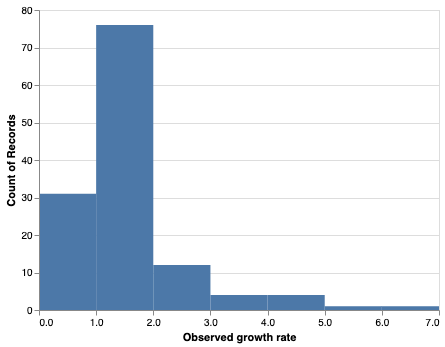

In [59]:
alt.Chart(complete_clade_frequencies).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

In [60]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [61]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year
0,2031-04-01,03167e3,0.16,0.98,0.61,6.125000,3.812500,2031
1,2031-04-01,1238505,0.47,0.98,0.72,2.085106,1.531915,2031
2,2031-04-01,236447c,0.93,1.00,0.98,1.075269,1.053763,2031
3,2031-04-01,30dddad,0.44,0.98,0.72,2.227273,1.636364,2031
4,2031-04-01,695af4b,0.26,0.02,0.21,0.076923,0.807692,2031


In [62]:
complete_clade_frequencies.shape

(129, 8)

In [63]:
r, p = pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

In [64]:
r

0.7305469071958913

In [65]:
p

8.76934029211108e-23

In [66]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [67]:
mcc

0.4479921000658328

In [68]:
confusion_matrix

{'tp': 85, 'tn': 18, 'fp': 13, 'fn': 13}

In [69]:
sum(confusion_matrix.values())

129

In [70]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.8673469387755102

In [71]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.5806451612903226

In [72]:
min_growth_rate = 0
max_growth_rate = complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [73]:
pseudofrequency = 0.001

In [74]:
complete_clade_frequencies["log_observed_growth_rate"] = (
    np.log10((complete_clade_frequencies["frequency_final"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

complete_clade_frequencies["log_estimated_growth_rate"] = (
    np.log10((complete_clade_frequencies["projected_frequency"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

In [75]:
upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())

log_lower_limit = complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

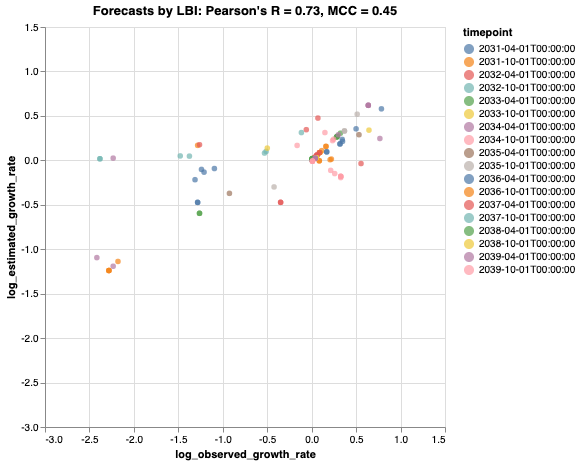

In [76]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("log_observed_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Y("log_estimated_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Color("timepoint:N"),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
).interactive()

#chart.save("forecast_log_growth_correlation_natural_lbi.svg")
chart

In [77]:
log_lower_limit

-2.516640507338281

In [78]:
complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min()

-2.416640507338281

In [79]:
r, p = pearsonr(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"]
)

In [80]:
r

0.7210379161004551

In [81]:
p

5.662142104343246e-22

In [82]:
pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

(0.7305469071958913, 8.76934029211108e-23)

In [83]:
complete_clade_frequencies["observed_growth"] = (complete_clade_frequencies["observed_growth_rate"] > 1)

In [84]:
complete_clade_frequencies["estimated_growth"] = (complete_clade_frequencies["estimated_growth_rate"] > 1)

In [85]:
complete_clade_frequencies.aggregate({"observed_growth": "sum", "estimated_growth": "sum"})

observed_growth     98
estimated_growth    98
dtype: int64

In [86]:
complete_clade_frequencies["accurate_growth"] = (
    (complete_clade_frequencies["observed_growth"]) == (complete_clade_frequencies["estimated_growth"])
)

In [87]:
confusion_matrix

{'tp': 85, 'tn': 18, 'fp': 13, 'fn': 13}

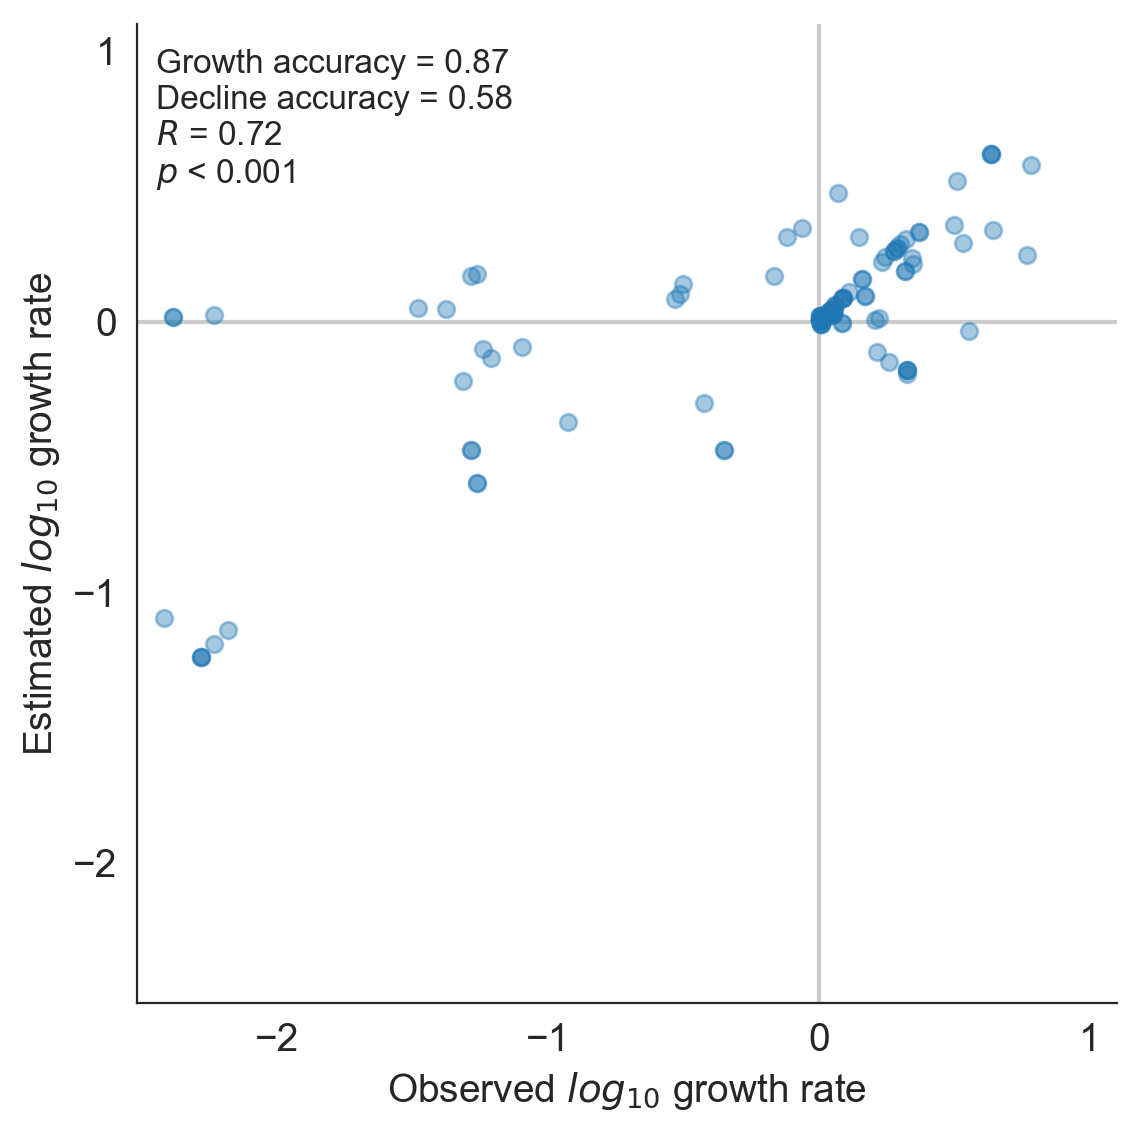

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

plt.tight_layout()
plt.savefig("../manuscript/figures/validation-of-best-model-for-simulated-populations-by-clade-growth.png")

In [89]:
false_positives = (complete_clade_frequencies["log_observed_growth_rate"] < 0) & (complete_clade_frequencies["log_estimated_growth_rate"] > 0)

In [90]:
confusion_matrix

{'tp': 85, 'tn': 18, 'fp': 13, 'fn': 13}

In [91]:
complete_clade_frequencies[false_positives].sort_values("frequency")

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate,observed_growth,estimated_growth,accurate_growth
78,2033-10-01,8d6504d,0.16,0.05,0.22,0.312500,1.375000,2033,-0.499256,0.137566,False,True,False
272,2037-10-01,8f812d8,0.17,0.13,0.35,0.764706,2.058824,2037,-0.115725,0.312311,False,True,False
362,2039-04-01,4e6e637,0.17,0.00,0.18,0.000000,1.058824,2039,-2.232996,0.024682,False,True,False
121,2034-10-01,d48329b,0.19,0.13,0.28,0.684211,1.473684,2034,-0.163762,0.167673,False,True,False
244,2037-04-01,a2f1320,0.20,0.01,0.30,0.050000,1.500000,2037,-1.261803,0.175370,False,True,False
215,2036-10-01,a125a94,0.21,0.01,0.31,0.047619,1.476190,2036,-1.282890,0.168478,False,True,False
32,2032-04-01,9c89bcc,0.23,0.20,0.51,0.869565,2.217391,2032,-0.060416,0.344809,False,True,False
39,2032-10-01,16b37cd,0.23,0.07,0.29,0.304348,1.260870,2032,-0.512354,0.100281,False,True,False
43,2032-10-01,5c73ba7,0.24,0.00,0.25,0.000000,1.041667,2032,-2.382017,0.017657,False,True,False
46,2032-10-01,9c89bcc,0.24,0.07,0.29,0.291667,1.208333,2032,-0.530759,0.081876,False,True,False


## Estimated and observed closest strains per timepoint

Create a figure similar to Figure 2D in Neher et al. 2014 showing the minimum estimated distance to the future and minimum observed distance to the future per timepoint.

In [92]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [93]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [94]:
sorted_df["timepoint_estimated_rank"] = sorted_df.groupby("timepoint")["y"].rank(pct=True)

In [95]:
sorted_df.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint,timepoint_rank,timepoint_estimated_rank
8820,2023-10-01,sample_4636_1,0.000013,6.303122,8.846077,14.429269,4.717925e-05,4.210202,2024-10-01,0.303175,0.249206
9236,2023-10-01,sample_4712_39,0.002323,5.657689,9.116452,4.757331,5.313585e-07,3.299014,2024-10-01,0.313492,0.099206
9237,2023-10-01,sample_4712_66,0.002323,6.586278,10.796369,4.198102,3.037508e-07,4.852093,2024-10-01,0.663492,0.439683
9238,2023-10-01,sample_4712_81,0.002323,7.768680,10.299197,1.165743,1.464134e-08,5.615084,2024-10-01,0.576984,0.530952
9239,2023-10-01,sample_4712_87,0.002323,7.789010,9.739459,1.977943,3.298485e-08,5.654458,2024-10-01,0.411111,0.549206


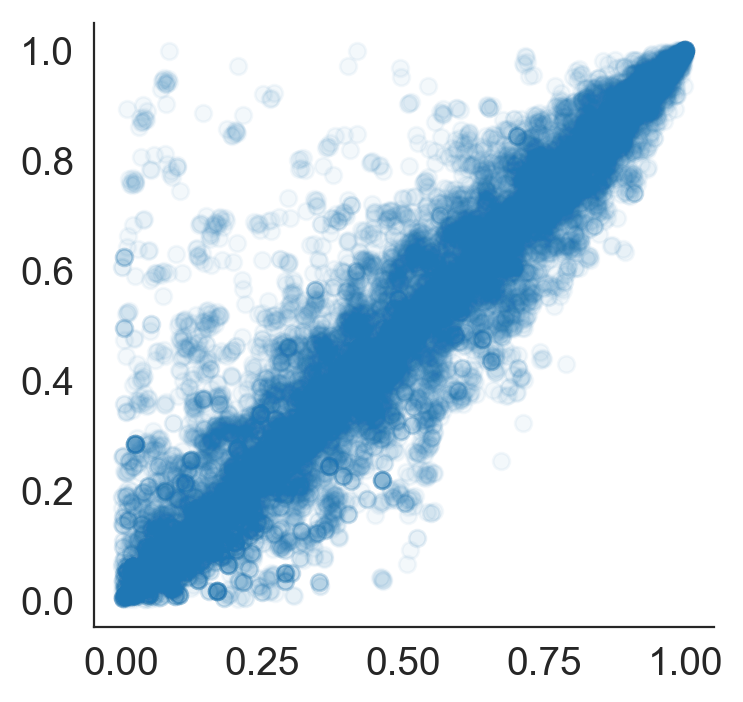

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(
    sorted_df["timepoint_rank"].values,
    sorted_df["timepoint_estimated_rank"],
    "o",
    alpha=0.05
)
#ax.set_xlim(0, 10)
#ax.set_ylim(0, 10)

In [97]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "y"],
    ascending=True
).groupby("timepoint")["timepoint_rank"].first().reset_index()

In [98]:
best_fitness_rank_by_timepoint_df.head()

,timepoint,timepoint_rank
0,2023-10-01,0.170635
1,2024-04-01,0.027778
2,2024-10-01,0.103175
3,2025-04-01,0.183333
4,2025-10-01,0.019048


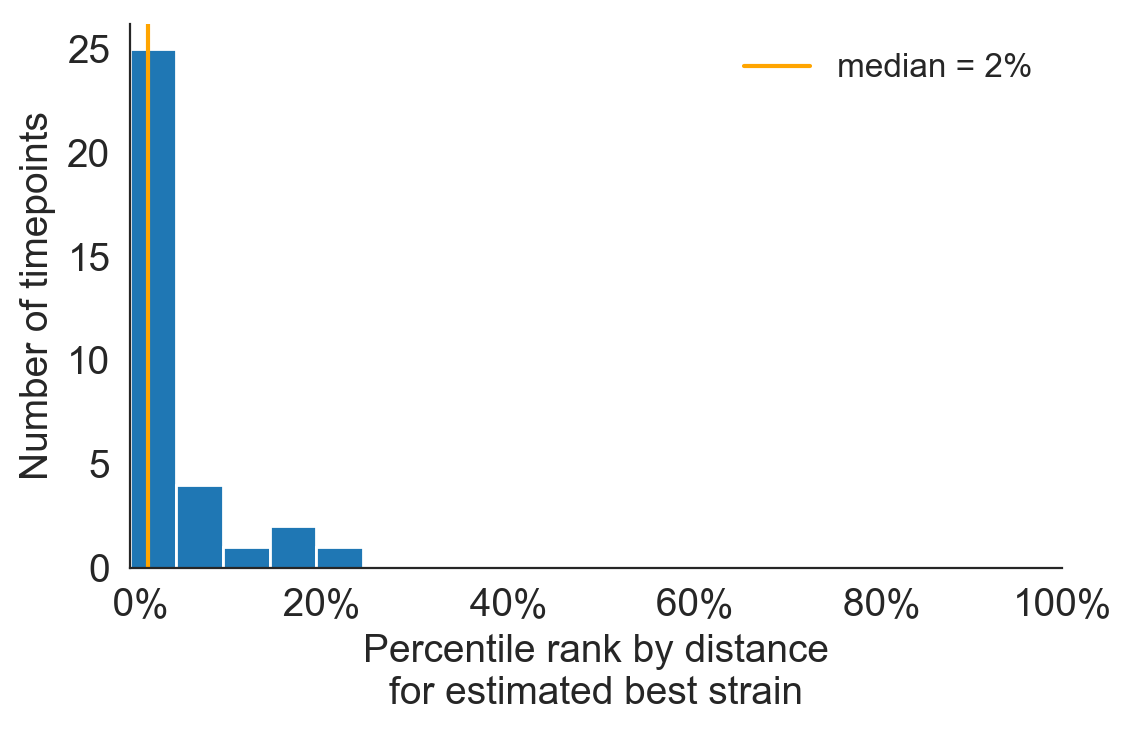

In [99]:
median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xlim(0, 1)

ax.legend(
    frameon=False
)
ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
ax.set_ylabel("Number of timepoints")

plt.tight_layout()
plt.savefig("../manuscript/figures/validation-of-best-model-for-simulated-populations-by-best-strain.png")

## Merge validation figures into subpanels of one figure

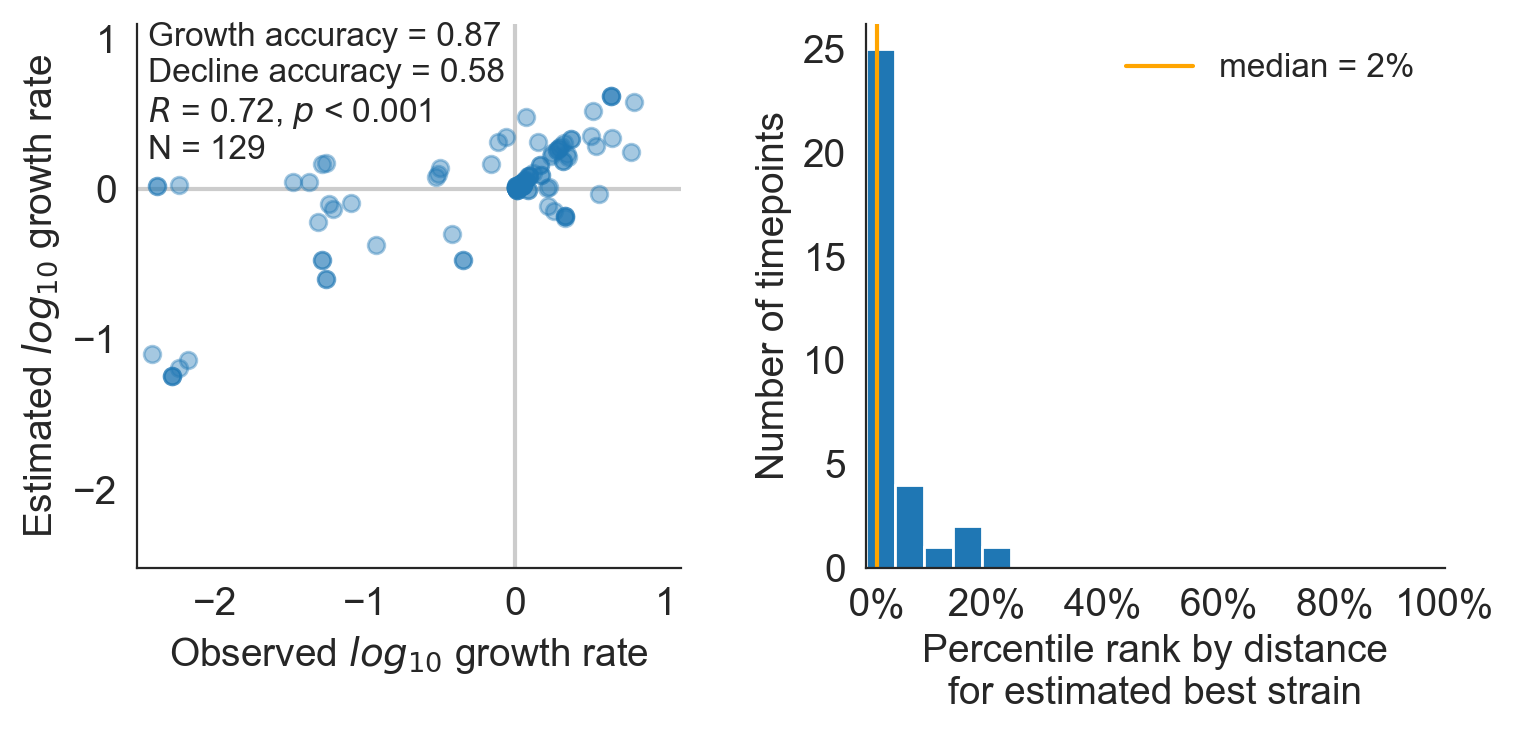

In [100]:
fig = plt.figure(figsize=(8, 4), facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.87,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f, %s\nN = %s" % (growth_accuracy, decline_accuracy, r, p_value, complete_clade_frequencies.shape[0]),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(ticks)
clade_ax.set_yticks(ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
rank_ax.set_ylabel("Number of timepoints")

gs.tight_layout(fig)

plt.savefig("../manuscript/figures/validation-of-best-model-for-simulated-populations.png")

In [107]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum()

32

In [108]:
best_fitness_rank_by_timepoint_df.shape

(33, 2)

In [109]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum() / float(best_fitness_rank_by_timepoint_df.shape[0])

0.9696969696969697

## Inspect uncertainty in forecast accuracy

Use observed forecasting errors to inspect the accuracy of one-year lookaheads based on the initial frequency of each clade.

In [104]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate,observed_growth,estimated_growth,accurate_growth
0,2031-04-01,03167e3,0.16,0.98,0.61,6.125000,3.812500,2031,0.784843,0.579215,True,True,True
1,2031-04-01,1238505,0.47,0.98,0.72,2.085106,1.531915,2031,0.318648,0.184914,True,True,True
2,2031-04-01,236447c,0.93,1.00,0.98,1.075269,1.053763,2031,0.031484,0.022719,True,True,True
3,2031-04-01,30dddad,0.44,0.98,0.72,2.227273,1.636364,2031,0.347230,0.213497,True,True,True
4,2031-04-01,695af4b,0.26,0.02,0.21,0.076923,0.807692,2031,-1.094421,-0.092358,False,False,True


In [105]:
complete_clade_frequencies["clade_error"] = complete_clade_frequencies["frequency_final"] - complete_clade_frequencies["projected_frequency"]

Text(0,0.5,'Forecast error (%)')

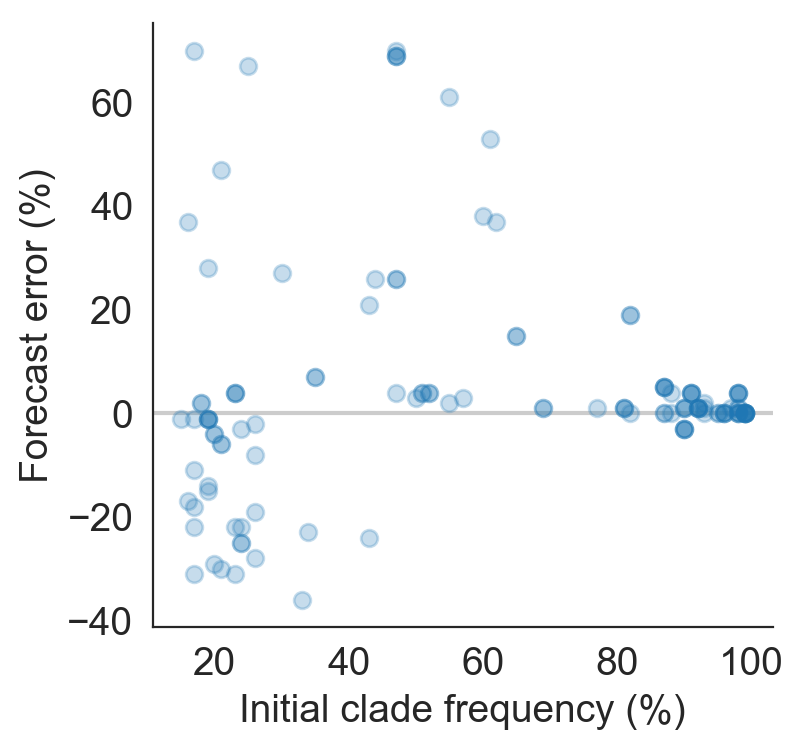

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(
    complete_clade_frequencies["frequency"].values * 100,
    complete_clade_frequencies["clade_error"].values * 100,
    "o",
    alpha=0.25
)
ax.axhline(0, color="#cccccc", zorder=-10)
ax.set_xlabel("Initial clade frequency (%)")
ax.set_ylabel("Forecast error (%)")